<a href="https://colab.research.google.com/github/ChristianWussow/Portfolio/blob/main/Data_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 

# <center>Data Analytics project: Property price prediction</center>

Online property companies offer valuations of houses using machine learning techniques. The aim of this project is to predict the house sales in King County, Washington State, USA using Multiple Linear Regression. The dataset consisted of historic data of houses sold between May 2014 to May 2015.
The dataset consists of house prices from King County an area in the US State of Washington, this data also covers Seattle. The dataset was obtained from Kaggle. The dataset consists of 21 variables and 21613 observations.



After data cleaning, exploratory data analysis and feature selectoin, we compare the model metrics of different regression models and also a deep learning architecutre. We also visualize the most impactful features with the SHAP library. 




### 1. Importing necessary tools:<a id='importing'></a>

In [ ]:
!pip install shap
import pandas as pd
import numpy as np
import scipy as scipy
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import shap

### 2. Dataset discovery:<a id='dataset_discovery'></a>

In [262]:
#  We look at the dataframe's shape

df = pd.read_csv('/content/drive/MyDrive/Phyton/Project/Project_2/Unit2-Project/kc_house_data.csv')

df.shape

(21613, 21)

In [38]:
# and the info

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21604 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21604 non-null  float64
 1   bedrooms       21604 non-null  int64  
 2   bathrooms      21604 non-null  float64
 3   sqft_living    21604 non-null  float64
 4   sqft_lot       21604 non-null  float64
 5   floors         21604 non-null  float64
 6   waterfront     21604 non-null  int64  
 7   view           21604 non-null  int64  
 8   condition      21604 non-null  int64  
 9   grade          21604 non-null  int64  
 10  sqft_above     21604 non-null  float64
 11  sqft_basement  21604 non-null  int64  
 12  yr_built       21604 non-null  float64
 13  yr_renovated   21604 non-null  float64
 14  zipcode        21604 non-null  float64
 15  lat            21604 non-null  float64
 16  long           21604 non-null  float64
 17  sqft_living15  21604 non-null  float64
 18  sqft_l

### 3. NA handling:<a id='na_handling'></a>
It is clear after printing the dataset info that there are some variables that have less entries than the number of rows which means that some of them don't have values in certain rows.

In [263]:
# we deal with the NAs in the dataset 
df.isnull().sum()

id               0
date             7
price            5
bedrooms         0
bathrooms        0
sqft_living      1
sqft_lot         1
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       4
sqft_basement    0
yr_built         2
yr_renovated     1
zipcode          2
lat              1
long             0
sqft_living15    1
sqft_lot15       0
dtype: int64

In [264]:
# we drop the rows with two or less missing values in a column

df.dropna(subset=['sqft_living', 'sqft_lot', 'yr_renovated', 'sqft_living15', 'lat', 'yr_built', 'zipcode'], inplace=True)

In [265]:
# we change the 'date' feature data type from object to datetime and look at the five most frequent dates

df['date'] = pd.to_datetime(df['date'])
df['date'].nunique()
df['date'].value_counts().head()

2014-06-23    142
2014-06-26    131
2014-06-25    131
2015-04-27    126
2014-07-08    126
Name: date, dtype: int64

In [266]:
# We fill in the missing values for the features with more than two missing values with the median or mode of the respective column

df['date'] = df['date'].fillna(value = df['date'].mode()[0])
df['price'] = df['price'].fillna(value = df['price'].median())
df['sqft_above'] = df['sqft_above'].fillna(value = df['sqft_above'].median())
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### 4. Useless variables deletion:<a id='useless_var'></a>
We want to eventually do a regression on it so naturally some variables bring no added value and can be delted without impacting the results.


In [267]:
# We delete the ID column as it does nor add any value
df.drop(['id'], inplace = True ,axis = 1)


### 5. Dataset discovery


In [ ]:
# shows the descripitve statistics for continuous data types

df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159900e+04,21604.000000,21604.000000,21604.000000,2.160400e+04,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000,21600.000000,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000,21604.000000
mean,5.401278e+05,3.370765,2.114597,2079.914507,1.510878e+04,1.494330,0.007545,0.234216,3.409461,7.656915,1788.463796,291.464775,1971.003240,84.437419,98077.938206,47.560055,-122.213881,1986.520644,12767.516756
std,3.670839e+05,0.929894,0.769987,918.411812,4.142878e+04,0.540005,0.086535,0.766036,0.650806,1.175461,828.173903,442.556510,29.373968,401.759208,53.498687,0.138559,0.140848,685.356289,27306.704373
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219750e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470975,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.617500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068725e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


[Text(0.5, 1.0, 'month_year')]

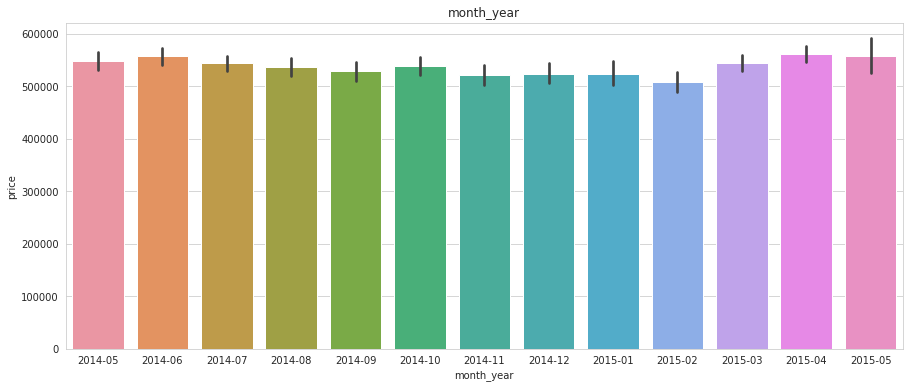

In [268]:
# date feature: we visualize the average price per month of the sale --> we cannot identify any significant impact

df['month_year'] = df['date'].dt.to_period('M')

plt.figure(figsize=(15,6))
sns.barplot(x=df['month_year'].sort_values(), 
             y=df['price']).set(title = df.month_year.name)

In [269]:
# we drop the 'data' and 'month_date' column as they are not relevant for our further analysis

df.drop(['date', 'month_year'], inplace = True ,axis = 1)

###yr_built feature:

[Text(0.5, 1.0, 'yr_built')]

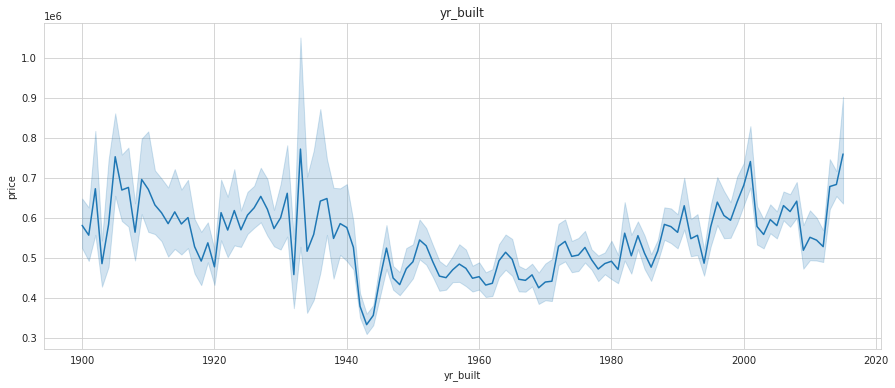

In [270]:
# yr_built feature: we explore if there is correlation between the price and the year the house was built

plt.figure(figsize=(15,6))
sns.lineplot(x=df['yr_built'].sort_values(), 
             y=df['price']).set(title = df.yr_built.name)

[Text(0.5, 1.0, 'yr_built')]

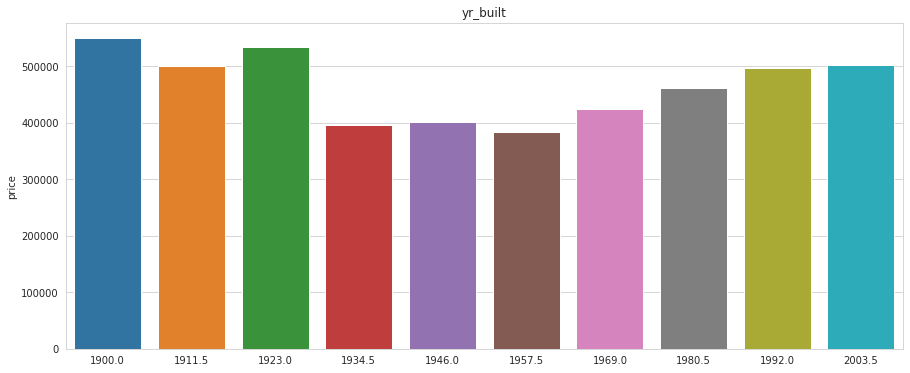

In [271]:
# we split the years into 10 bins and calcualte the median price for each period

n_bins = 10

x_bins = np.arange(n_bins)

_, bins = pd.cut(df['yr_built'], bins=n_bins, retbins=True, right=False)

binned_data = df['price'].groupby(np.digitize(df['yr_built'], bins)).median()
plt.figure(figsize=(15,6))
sns.barplot(x=bins[:10], 
             y=binned_data).set(title = df.yr_built.name)

In [272]:
# we assign each value to one of the binned classes

for i in range(bins.shape[0]-1):
  df['yr_built'] = df.yr_built.apply(lambda x: bins[i] if x < float(bins[i+1]) and x >=float(bins[i]) else x)


###yr_renovated feature:

[Text(0.5, 1.0, 'yr_renovated')]

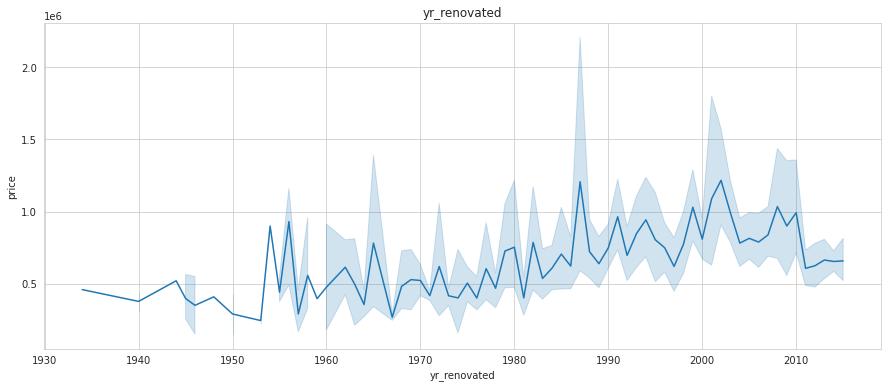

In [273]:
# yr_built feature: we explore if there is correlation between the price and the year the house was built
# we exclude the houses with a zero value

ren_notnull= df.yr_renovated.loc[df['yr_renovated'] != 0]
plt.figure(figsize=(15,6))
sns.lineplot(x= ren_notnull, 
             y=df['price']).set(title = df.yr_renovated.name)

[Text(0.5, 1.0, 'yr_renovated')]

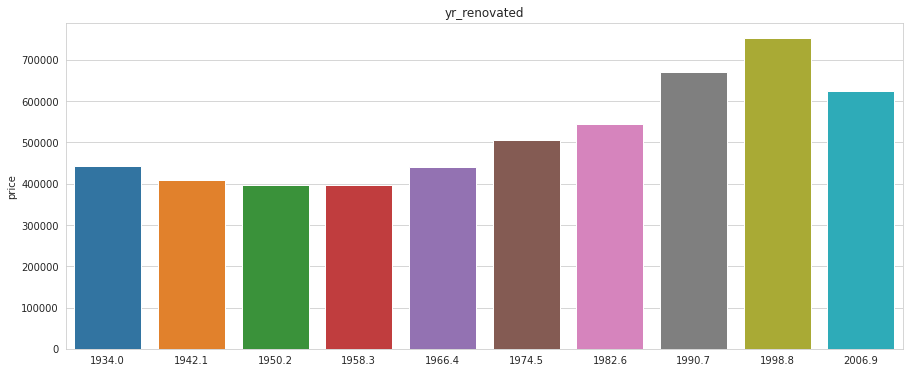

In [274]:
n_bins = 10

x_bins = np.arange(n_bins)

_, bins = pd.cut(ren_notnull, bins=n_bins, retbins=True, right=False)

binned_data = df['price'].loc[df['yr_renovated'] != 0].groupby(np.digitize(ren_notnull, bins)).median()
plt.figure(figsize=(15,6))
sns.barplot(x=bins[:-1], 
             y=binned_data).set(title = df.yr_renovated.name)

In [275]:
# we assign each value to one of the binned classes

for i in range(bins.shape[0]-1):
  df['yr_renovated'] = df.yr_renovated.apply(lambda x: bins[i] if x < float(bins[i+1]) and x >=float(bins[i]) else x)

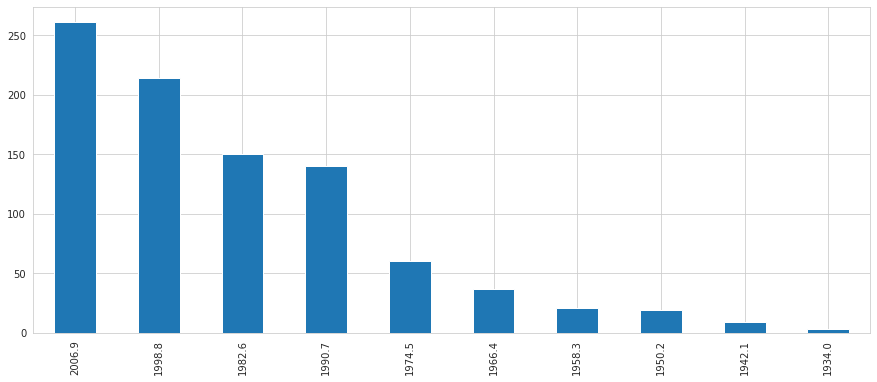

In [246]:
plt.figure(figsize=(15,6))
df.yr_renovated.loc[df['yr_renovated'] != 0].value_counts().plot(kind='bar')

### zipcode feature:

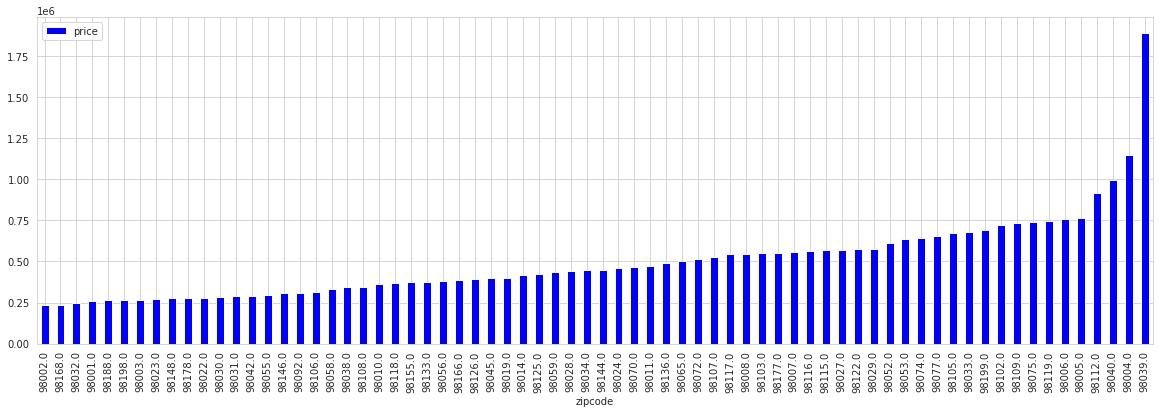

In [247]:
# we order the zipcode according to the correlation with price

df.price.groupby(df.zipcode).median().sort_values().plot(kind = 'bar', color= 'blue', legend=True, figsize=(20,6))

In [276]:

# we ordinal encode the zipcode column into 6 groups in respect to the median house price of each zip code

zip = pd.DataFrame(df.price.groupby(df.zipcode).median().sort_values().reset_index())

zip_list = list(zip.iloc[:,0])

df['zipcode'] = df.zipcode.apply(lambda x: 6 if x == zip_list[-1] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 5 if x in zip_list[-4:-1] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 4 if x in zip_list[-13:-4] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 3 if x in zip_list[-33:-13] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 2 if x in zip_list[-50:-33] else x)
df['zipcode'] = df.zipcode.apply(lambda x: 1 if x in zip_list[:-50] else x)
df['zipcode'].value_counts()

3.0    6812
1.0    6064
2.0    5411
4.0    2400
5.0     867
6.0      50
Name: zipcode, dtype: int64

##Features on a continuous scale:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.3, 0.8, 'skewness: -0.49')

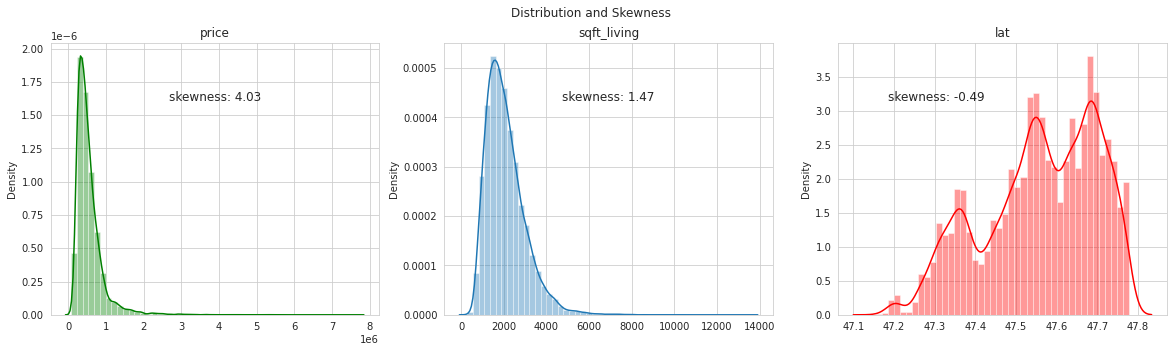

In [277]:
# we take a look at the distribution and the skewness of certain features

skew_price = str(round(df.price.skew(),2))
skew_sqrt = str(round(df.sqft_living.skew(),2))
skew_lat = str(round(df.lat.skew(),2))

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(20,5))
fig.suptitle('Distribution and Skewness')

sns.distplot(ax=axes[0], x=df.price, color = 'green')
axes[0].set_title(df.price.name)
axes[0].text(0.5,0.8,'skewness: '+ skew_price, fontsize=12, horizontalalignment='center',
     verticalalignment='center', transform=axes[0].transAxes)

sns.distplot(ax=axes[1], x=df.sqft_living)
axes[1].set_title(df.sqft_living.name)
axes[1].text(0.5,0.8,'skewness: '+ skew_sqrt, fontsize=12, horizontalalignment='center',
     verticalalignment='center', transform=axes[1].transAxes)

sns.distplot(ax=axes[2], x=df.lat, color = 'red')
axes[2].set_title(df.lat.name)
axes[2].text(0.3,0.8,'skewness: '+ skew_lat, fontsize=12, horizontalalignment='center',
     verticalalignment='center', transform=axes[2].transAxes)

##Ordinal features:
we group them and calculate the mean of each class to evaluate a possible correlaton with the house price

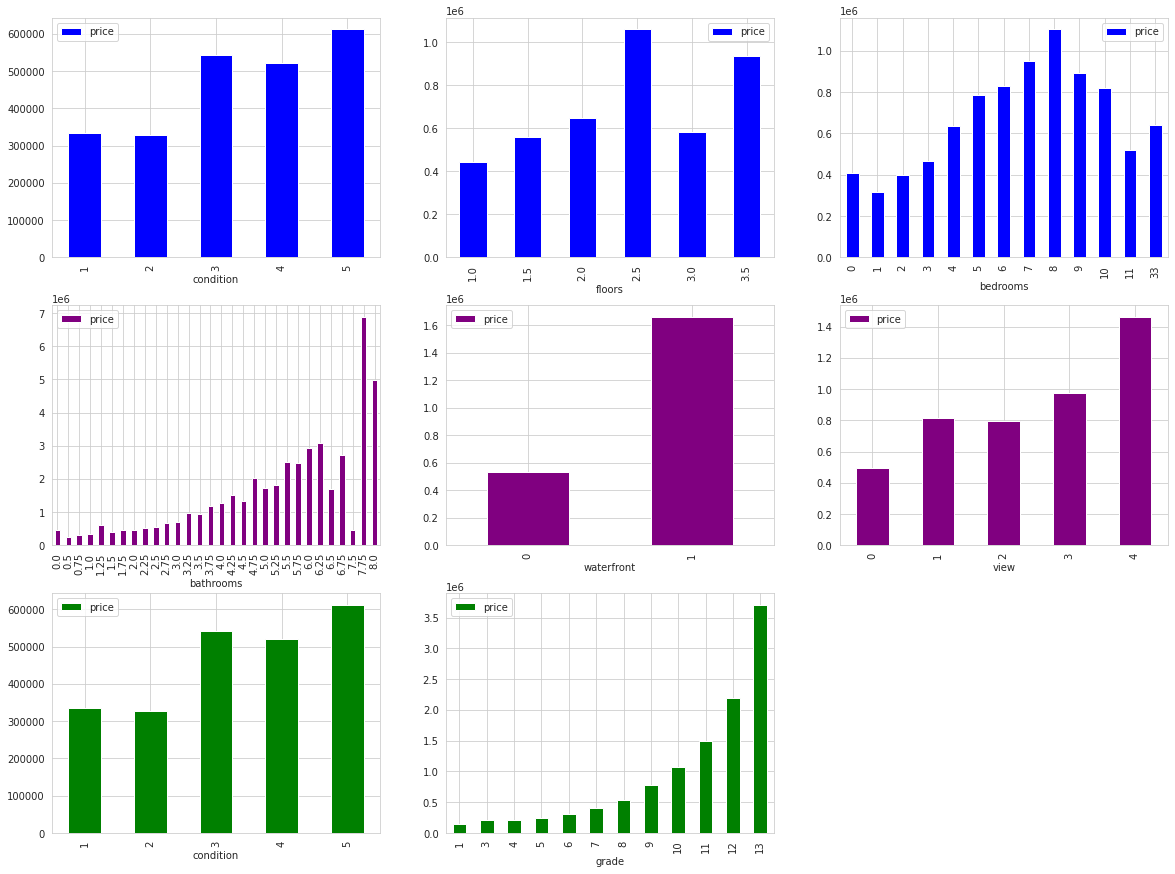

In [250]:
fig = plt.figure(figsize=(20,15))

ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)

df.price.groupby(df.condition).mean().plot(kind = 'bar', color= 'blue', legend=True, ax=ax1)
df.price.groupby(df.floors).mean().plot(kind = 'bar', color= 'blue', legend=True, ax=ax2)
df.price.groupby(df.bedrooms).mean().plot(kind = 'bar', color= 'blue', legend=True, ax=ax3)
df.price.groupby(df.bathrooms).mean().plot(kind = 'bar', color= 'purple', legend=True, ax=ax4)
df.price.groupby(df.waterfront).mean().plot(kind = 'bar', color= 'purple', legend=True, ax=ax5)
df.price.groupby(df.view).mean().plot(kind = 'bar', color= 'purple', legend=True, ax=ax6)
df.price.groupby(df.condition).mean().plot(kind = 'bar', color= 'green', legend=True, ax=ax7)
df.price.groupby(df.grade).mean().plot(kind = 'bar', color= 'green', legend=True, ax=ax8)


### 6.Outliers detection:<a id='outliers'></a>
Having outliers is a common problem that might affect the quality of the model that we're building.

Let's assume that we're not interested in very expensive or very cheap houses, we want a model that best fits the average priced houses.

To create such a model, we detect outliers and delete them using the Z-score method seen in the lessons.

In [278]:
# To-Do : detect the outliers then delete them ad delete the column created to calculate the Z-score
# calculte z-score for continuous variables --> we assign binary and ordinal varibales to cols

from scipy import stats
cols = ['waterfront', 'yr_renovated','view', 'condition', 'bedrooms', 'zipcode', 'lat', 'grade']
df_z = df.copy()
df_z = df_z[[i for i in list(df_z.columns) if i not in cols]]

for i in list(df_z.columns):
  df_z[i + '_zscore'] = stats.zscore(df_z[i])

In [ ]:
df_z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21604 entries, 0 to 21612
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 21604 non-null  float64
 1   bathrooms             21604 non-null  float64
 2   sqft_living           21604 non-null  float64
 3   sqft_lot              21604 non-null  float64
 4   floors                21604 non-null  float64
 5   grade                 21604 non-null  int64  
 6   sqft_above            21604 non-null  float64
 7   sqft_basement         21604 non-null  int64  
 8   yr_built              21604 non-null  float64
 9   long                  21604 non-null  float64
 10  sqft_living15         21604 non-null  float64
 11  sqft_lot15            21604 non-null  int64  
 12  price_zscore          21604 non-null  float64
 13  bathrooms_zscore      21604 non-null  float64
 14  sqft_living_zscore    21604 non-null  float64
 15  sqft_lot_zscore    

In [279]:
# for some columns we stats.zscore method didn't work so we calculte the z-score manually

df_z['sqft_living_zscore'] = (df['sqft_living'] - df['sqft_living'].mean()) / df['sqft_living'].std()

df_z['price_zscore'] = (df['price'] - df['price'].mean()) / df['price'].std()

df_z['sqft_above_zscore'] = (df['sqft_above'] - df['sqft_above'].mean()) / df['sqft_above'].std()



In [253]:
df_z['price_zscore'].describe()


count    2.160400e+04
mean    -8.419688e-17
std      1.000000e+00
min     -1.267170e+00
25%     -5.942258e-01
50%     -2.454937e-01
75%      2.857778e-01
max      1.950691e+01
Name: price_zscore, dtype: float64

In [280]:
# we exclude all rows with outliers --> - 3 < z > 3

for i in list(df.columns):
 if i not in cols:
  df = df[abs(df_z[i + '_zscore'] < 3)]
df.head()

Boolean Series key will be reindexed to match DataFrame index.


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180.0,5650.0,1.0,0,0,3,7,1180.0,0,1946.0,0.0,1.0,47.5112,-122.257,1340.0,5650
1,538000.0,3,2.25,2570.0,7242.0,2.0,0,0,3,7,2170.0,400,1946.0,1990.7,2.0,47.7210,-122.319,1690.0,7639
2,180000.0,2,1.00,770.0,10000.0,1.0,0,0,3,6,770.0,0,1923.0,0.0,2.0,47.7379,-122.233,2720.0,8062
3,604000.0,4,3.00,1960.0,5000.0,1.0,0,0,5,7,1050.0,910,1957.5,0.0,3.0,47.5208,-122.393,1360.0,5000
4,510000.0,3,2.00,1680.0,8080.0,1.0,0,0,3,8,1680.0,0,1980.5,0.0,3.0,47.6168,-122.045,1800.0,7503


In [255]:
# we can see a reduction in rows

print(df.shape)
print(df_z.shape)

(20076, 19)
(21604, 22)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.8, 0.8, 'skewness: 0.63')

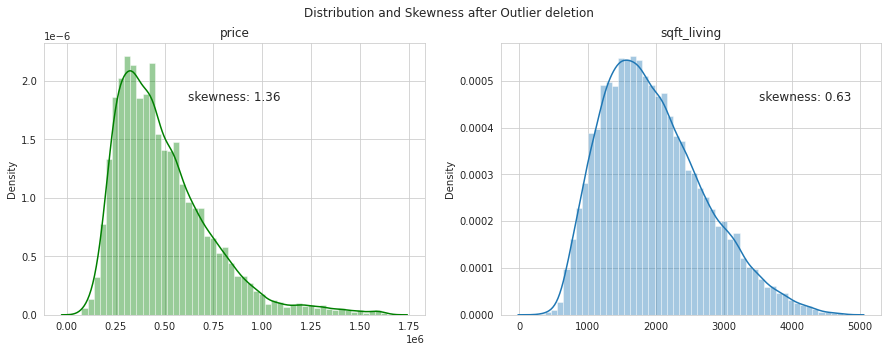

In [256]:
# after we eliminated the outliers we eliminated most of the skewness
# we visualize the ditribution of the price and the sqft_living features and display the skewness factor after we have eliminated outliers
# --> so we don't need to transform our features


skew_price = str(round(df.price.skew(),2))
skew_sqrt = str(round(df.sqft_living.skew(),2))

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('Distribution and Skewness after Outlier deletion')

sns.distplot(ax=axes[0], x=df.price, color = 'green')
axes[0].set_title(df.price.name)
axes[0].text(0.5,0.8,'skewness: '+ skew_price, fontsize=12, horizontalalignment='center',
     verticalalignment='center', transform=axes[0].transAxes)

sns.distplot(ax=axes[1], x=df.sqft_living)
axes[1].set_title(df.sqft_living.name)
axes[1].text(0.8,0.8,'skewness: '+ skew_sqrt, fontsize=12, horizontalalignment='center',
     verticalalignment='center', transform=axes[1].transAxes)

### 7.Feature selection:<a id='feature_selection'></a>
It is clear that even after deleting some features, there might be other features that aren't obviously useless but can be delted and keep a good overall performance.

To verify this, we perform feature selection on our variables.

#### Correlation

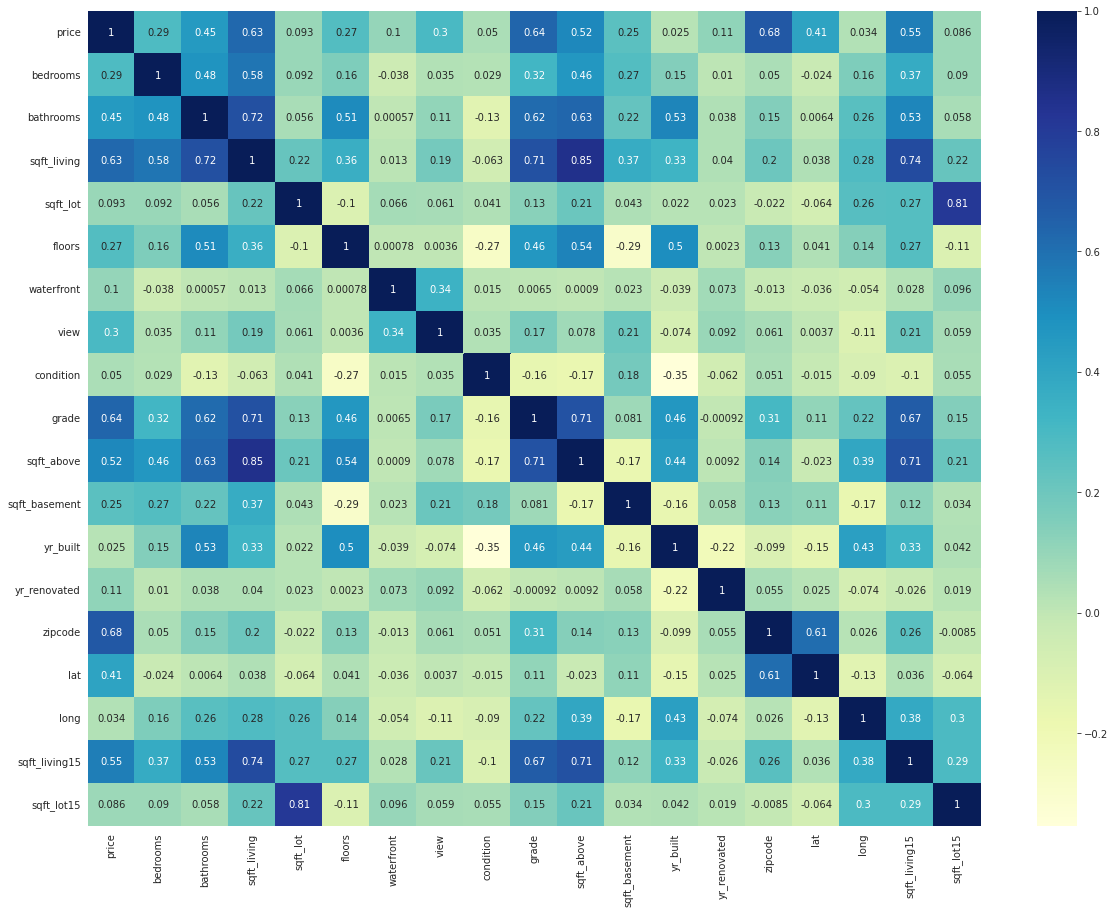

In [281]:
# We perform feature selection using correlation
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


In [286]:
# we only want to work with continuous variables with a correlation > 0.1
# we also add the ordinal variable 'condition' and 'yr_built' manually for later one hot encoding. Those two features do not survive our correlation filter. 

col = [i for i in list(df.columns) if df[i].corr(df['price']) > 0.1]
df = df[col + ['condition'] + ['yr_built']]
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated',
       'zipcode', 'lat', 'sqft_living15', 'condition', 'yr_built'],
      dtype='object')

In [288]:
# we drop 'sqft_above', 'sqft_living15' as the are highly correlated with 'sqft_living'

df.drop(['sqft_above', 'sqft_living15'], axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20076 entries, 0 to 21612
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20076 non-null  float64
 1   bedrooms       20076 non-null  int64  
 2   bathrooms      20076 non-null  float64
 3   sqft_living    20076 non-null  float64
 4   floors         20076 non-null  float64
 5   waterfront     20076 non-null  int64  
 6   view           20076 non-null  int64  
 7   grade          20076 non-null  int64  
 8   sqft_basement  20076 non-null  int64  
 9   yr_renovated   20076 non-null  float64
 10  zipcode        20076 non-null  float64
 11  lat            20076 non-null  float64
 12  condition      20076 non-null  int64  
 13  yr_built       20076 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 2.3 MB



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Train Test Split

In [289]:
x = df.loc[:,df.columns != 'price']

y = df['price']

In [290]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.3)

#### OneHotEncoding and Scaling

In [291]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder

# we want to standardize continuous features and one hot encode binary and ordinal features so we separate the columns

columns_to_encode = ['view','waterfront','condition', 'zipcode', 'yr_built', 'yr_renovated']
columns_to_scale  = [i for i in x_train.columns if i not in columns_to_encode]

s = StandardScaler()
o = OneHotEncoder(sparse=False)


scaled_columns_train  = pd.DataFrame(s.fit_transform(x_train[columns_to_scale]), columns= [columns_to_scale]) 

encoded_columns_train =  pd.DataFrame(o.fit_transform(x_train[columns_to_encode]))


scaled_columns_test  = pd.DataFrame(s.transform(x_test[columns_to_scale]), columns= [columns_to_scale]) 

encoded_columns_test =  pd.DataFrame(o.transform(x_test[columns_to_encode]))



complete_cols = columns_to_scale + list(o.get_feature_names_out(columns_to_encode))

# we concantenate the transformned columns

processed_data_train = pd.DataFrame(np.concatenate([scaled_columns_train, encoded_columns_train], axis=1), columns = complete_cols)

processed_data_test = pd.DataFrame(np.concatenate([scaled_columns_test, encoded_columns_test], axis=1), columns = complete_cols)



x_train = processed_data_train

x_test = processed_data_test

#8.Linear regression:<a id='linear_reg'></a>
We compare different LR models with different polynomial degrees and with and without regularization.



In [292]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [293]:
# ordinary LR

lr = LinearRegression(fit_intercept=False).fit(x_train, y_train)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("MSE: ", round(mean_squared_error(y_test, y_pred),2))
print('R squared training set: ', round(lr.score(x_train, y_train)*100, 2))
print('R squared test set: ', round(lr.score(x_test, y_test)*100, 2))

MSE:  11721264312.09
R squared training set:  80.5
R squared test set:  80.76


In [294]:
# polynomial linear regression --> overfitting

poly_reg_n=PolynomialFeatures(degree=2)
x_poly_train=poly_reg_n.fit_transform(x_train)
x_poly_test=poly_reg_n.transform(x_test)
poly_reg_n.fit(x_poly_train,y_train)
lrn=LinearRegression(fit_intercept=False)
lrn.fit(x_poly_train,y_train)
y_pred = lrn.predict(x_poly_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("Poly R2 Train: ", round(lrn.score(x_poly_train, y_train)*100, 2))
print("Poly R2 Test: ", round(lrn.score(x_poly_test, y_test)*100, 2))

MSE:  1.9266796704026242e+29
Poly R2 Train:  85.87
Poly R2 Test:  -3.1618089002834336e+20


In [295]:
# Lsso LR

reg = Lasso(alpha=1, fit_intercept = False, max_iter=5000)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("MSE: ", round(mean_squared_error(y_test, y_pred),2))
print('Lasso R squared training set: ', round(reg.score(x_train, y_train)*100, 2))
print('Lasso R squared test set: ', round(reg.score(x_test, y_test)*100, 2))


MSE:  11721452442.63
Lasso R squared training set:  80.5
Lasso R squared test set:  80.76


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.022e+13, tolerance: 4.287e+11


In [296]:
# Ridge LR

reg = Ridge(alpha=1, fit_intercept=False)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print('Ridge R squared training set: ', round(reg.score(x_train, y_train)*100, 2))
print('Ridge R squared test set: ', round(reg.score(x_test, y_test)*100, 2))

MSE:  11723002921.239002
Ridge R squared training set:  80.5
Ridge R squared test set:  80.76


In [297]:
# Lasso LR with Polynomial Degrees of 2

poly_reg_2=PolynomialFeatures(degree=2)
x_poly_train=poly_reg_2.fit_transform(x_train)
x_poly_test=poly_reg_2.transform(x_test)
poly_reg_2.fit(x_poly_train,y_train)
lr4=Lasso(alpha= 6, fit_intercept=False)
lr4.fit(x_poly_train,y_train)
y_pred = lr4.predict(x_poly_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("Lasso R2 Train: ", round(lr4.score(x_poly_train, y_train)*100, 2))
print("Lasso R2 Test: ", round(lr4.score(x_poly_test, y_test)*100, 2))

MSE:  9901248118.103146
Lasso R2 Train:  85.77
Lasso R2 Test:  83.75


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.160e+13, tolerance: 4.287e+11


In [300]:
# best result on test set with Ridge LR with Polynomial Degrees of 2

poly_reg_2=PolynomialFeatures(degree=2)
x_poly_train=poly_reg_2.fit_transform(x_train)
x_poly_test=poly_reg_2.transform(x_test)
poly_reg_2.fit(x_poly_train,y_train)
lr4=Ridge(alpha= 7, fit_intercept=False)
lr4.fit(x_poly_train,y_train)
y_pred = lr4.predict(x_poly_test)
print("MSE: ", mean_squared_error(y_test, y_pred))
print("Ridge R2 Train: ", round(lr4.score(x_poly_train, y_train)*100, 2))
print("Ridge R2 Test: ", round(lr4.score(x_poly_test, y_test)*100, 2))

MSE:  9767030550.464035
Ridge R2 Train:  85.56
Ridge R2 Test:  83.97


##Bonus: Neural Network and SHAP

In [301]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Softmax, Conv2D, MaxPooling2D, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.initializers import HeNormal, GlorotNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import keras
from keras import models


In [302]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

early_stopping.monitor='val_loss'
early_stopping.patience = 10

In [303]:
model=Sequential([
    Dense(units = 32, activation = 'LeakyReLU', kernel_initializer='he_normal', kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dense(units = 64, activation = 'LeakyReLU', kernel_initializer='he_normal', kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dense(units = 128, activation = 'LeakyReLU', kernel_initializer='he_normal', kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dropout(0.3),
    Dense(units = 64, activation = 'LeakyReLU', kernel_initializer='he_normal',kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dropout(0.3),
    Dense(units = 32, activation = 'LeakyReLU', kernel_initializer='he_normal', kernel_regularizer= regularizers.l1_l2(0.001)), BatchNormalization(),
    Dense(units = 1, activation = 'LeakyReLU', kernel_initializer='he_normal')    
])

In [304]:
model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.01), metrics = ['mse'])
        
model_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 50, verbose=1, callbacks=[early_stopping])

Epoch 1/50
440/440 [==============================] - 5s 4ms/step - loss: 304323657728.0000 - mse: 304323657728.0000 - val_loss: 301894041600.0000 - val_mse: 301894041600.0000
Epoch 2/50
440/440 [==============================] - 1s 3ms/step - loss: 299892539392.0000 - mse: 299892539392.0000 - val_loss: 294068355072.0000 - val_mse: 294068355072.0000
Epoch 3/50
440/440 [==============================] - 2s 5ms/step - loss: 291527720960.0000 - mse: 291527720960.0000 - val_loss: 285922230272.0000 - val_mse: 285922230272.0000
Epoch 4/50
440/440 [==============================] - 2s 4ms/step - loss: 280040538112.0000 - mse: 280040538112.0000 - val_loss: 274912772096.0000 - val_mse: 274912772096.0000
Epoch 5/50
440/440 [==============================] - 2s 3ms/step - loss: 266060447744.0000 - mse: 266060447744.0000 - val_loss: 256093847552.0000 - val_mse: 256093847552.0000
Epoch 6/50
440/440 [==============================] - 2s 3ms/step - loss: 250421837824.0000 - mse: 250421837824.0000 - v

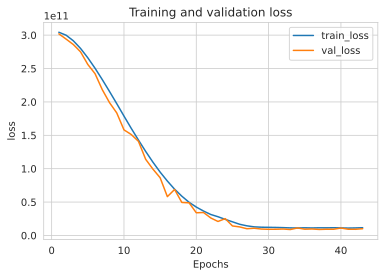

In [307]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(model_history, 'loss')

In [308]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [309]:
y_pred = model.predict(x_test)

y_pred =y_pred[:,0]
y_pred =y_pred
y_pred.shape
y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)
y_pred=tf.convert_to_tensor(y_pred,dtype=tf.float64)


print(coeff_determination(y_test,y_pred))

189/189 [==============================] - 0s 1ms/step
tf.Tensor(0.8341044494041259, shape=(), dtype=float64)


R2 of our neural network: 0.83

This is slightly less than the value we had in our polynomial Ridge regression with 83.97.

## SHAP
we want to see which features are the most relevant for our prediction

In [ ]:
explainer = shap.explainers.Linear(lr,x_train)
shap_values = explainer.shap_values(x_train)

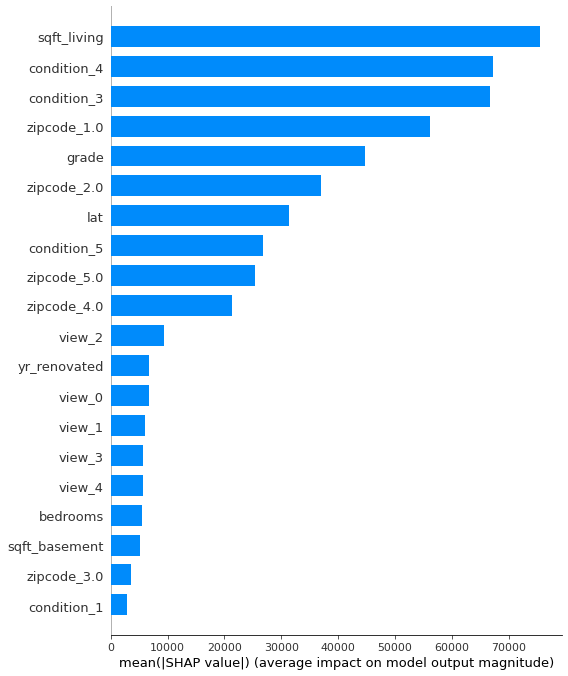

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type='bar')